# Прогнозирование статуса студента

На основе данных об абитуриенте, необходимо разработать модель, которая будет предсказывать текущий
статус студента, а именно:
- продолжит ли студент обучение
- отчислится
- возьмет академический отпуск

Решение задачи будем осуществлять в следующей последовательности:
1. Загрузка и первичный анализ данных.
2. Подготовка данных к обучению модели.
3. Построение модели машинного обучения.
4. Формирование файла с ответом, анализ результата и вывод

In [1]:
# Загрузим нужные библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer, MinMaxScaler, Normalizer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV
import re
from random import randint
from catboost import CatBoostClassifier, Pool, cv
from sklearn.linear_model import LogisticRegression

# from sklearn.ensemble import StackingClassifier, VotingClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import shap
# %matplotlib inline

In [2]:
# pip install XGBoost

In [3]:
# pip install shap

## 1. Загрузка и первичный анализ данных

In [4]:
# Загрузка данных
df = pd.read_csv("train_dataset_train.csv", parse_dates=['Дата_Рождения'])
df_test = pd.read_csv("test_dataset_test.csv", parse_dates=['Дата_Рождения'])
df_submission = pd.read_csv("sample_submission.csv")

In [5]:
df.head(3)

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
0,72716,16019,2015,Жен,ОО,Английский язык,1998-02-08,"МБОУ ""СОШ №59""","Алтайский край, Барнаул г",2014.0,...,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3
1,63306,14895,2010,Муж,ЦН,NaN,1992-04-18,NaN,NaN,NaN,...,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4
2,82469,20103,2017,Жен,ДН,Английский язык,1999-03-21,МБОУ Алтайская СОШ №5,"Алтайский край, Алтайский р-н, Алтайское с",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13584 entries, 0 to 13583
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID                13584 non-null  int64         
 1   Код_группы        13584 non-null  int64         
 2   Год_Поступления   13584 non-null  int64         
 3   Пол               13577 non-null  object        
 4   Основания         13584 non-null  object        
 5   Изучаемый_Язык    12758 non-null  object        
 6   Дата_Рождения     13584 non-null  datetime64[ns]
 7   Уч_Заведение      12351 non-null  object        
 8   Где_Находится_УЗ  12203 non-null  object        
 9   Год_Окончания_УЗ  12284 non-null  float64       
 10  Пособие           12576 non-null  float64       
 11  Страна_ПП         13237 non-null  object        
 12  Регион_ПП         12966 non-null  object        
 13  Город_ПП          13141 non-null  object        
 14  Общежитие         1349

In [7]:
df.describe()

,ID,Код_группы,Год_Поступления,Год_Окончания_УЗ,Пособие,Общежитие,Наличие_Матери,Наличие_Отца,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
count,13584.000000,13584.000000,13584.000000,12284.000000,12576.0,13498.000000,13584.000000,13584.000000,13584.000000,13498.000000,13274.000000,13584.000000,13584.000000,13584.000000
mean,70096.056905,18302.499926,2014.992123,2013.876018,0.0,0.219884,0.511484,0.509570,0.000442,0.229441,0.070589,32.500368,73.223274,3.426458
std,12705.894531,2540.417956,2.595339,4.247111,0.0,0.414184,0.499886,0.499927,0.021013,0.420489,0.256147,8.458150,258.045027,1.071765
min,44632.000000,11550.000000,2001.000000,1973.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,-1.000000
25%,63496.750000,16901.000000,2013.000000,2013.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,47.000000,3.000000
50%,71401.500000,18534.500000,2015.000000,2015.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,28.000000,61.000000,4.000000
75%,78404.250000,20599.000000,2016.000000,2016.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,40.000000,75.000000,4.000000
max,264403.000000,22824.000000,2212.000000,2020.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,53.000000,5000.000000,4.000000


In [8]:
df_test.describe()

,ID,Код_группы,Год_Поступления,Год_Окончания_УЗ,Пособие,Общежитие,Наличие_Матери,Наличие_Отца,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата
count,6691.000000,6691.000000,6691.000000,6074.000000,6207.0,6656.000000,6691.000000,6691.000000,6691.000000,6654.000000,6561.000000,6691.000000,6691.000000
mean,70202.034225,18310.805111,2014.991929,2013.800955,0.0,0.223407,0.501270,0.500673,0.000897,0.223024,0.071026,32.560155,71.681369
std,12763.462061,2523.533176,1.950492,4.450884,0.0,0.416560,0.500036,0.500037,0.029934,0.416305,0.256887,8.514496,250.386989
min,44602.000000,11574.000000,2006.000000,1966.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000
25%,64919.500000,16891.500000,2013.000000,2013.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,47.000000
50%,71380.000000,18537.000000,2015.000000,2015.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,28.000000,61.000000
75%,78370.500000,20601.000000,2016.000000,2016.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,40.000000,76.000000
max,194044.000000,22753.000000,2020.000000,2020.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,53.000000,7232.000000


In [9]:
df['Страна_ПП'].unique()

array(['Россия', nan, 'Казахстан', 'Кыргызстан', 'Китай', 'Таджикистан',
       'Казахстан Респ', 'Киргизия', 'Казахстан респ', 'РОССИЯ',
       'Армения', 'Туркменистан', 'Нигерия', 'Таджикистан Респ',
       'Росссия', 'Узбекистан', 'Кыргызия', 'Франция',
       'Кыргызская Республика', 'Монголия', 'Казахстан ВКО',
       'Республика Казахстан', 'Республика Таджикистан', 'Украина'],
      dtype=object)

Пострим на распределение данных

Text(0.5, 1.0, 'Распределение предсказываемой величены')

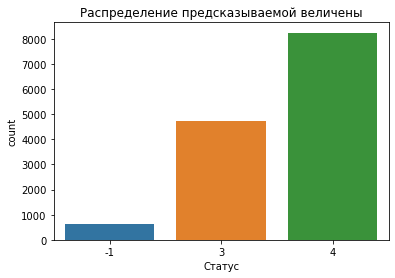

In [10]:
sns.countplot(x = "Статус" , data  = df).set_title('Распределение предсказываемой величены')

Text(0.5, 1.0, 'Распределение года поступления')

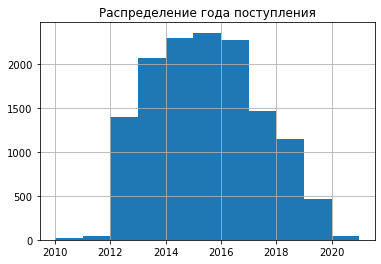

In [11]:
df["Год_Поступления"].hist(bins = 11, range = [2010, 2021]).set_title('Распределение года поступления')

Взглянем на несколько величин сразу

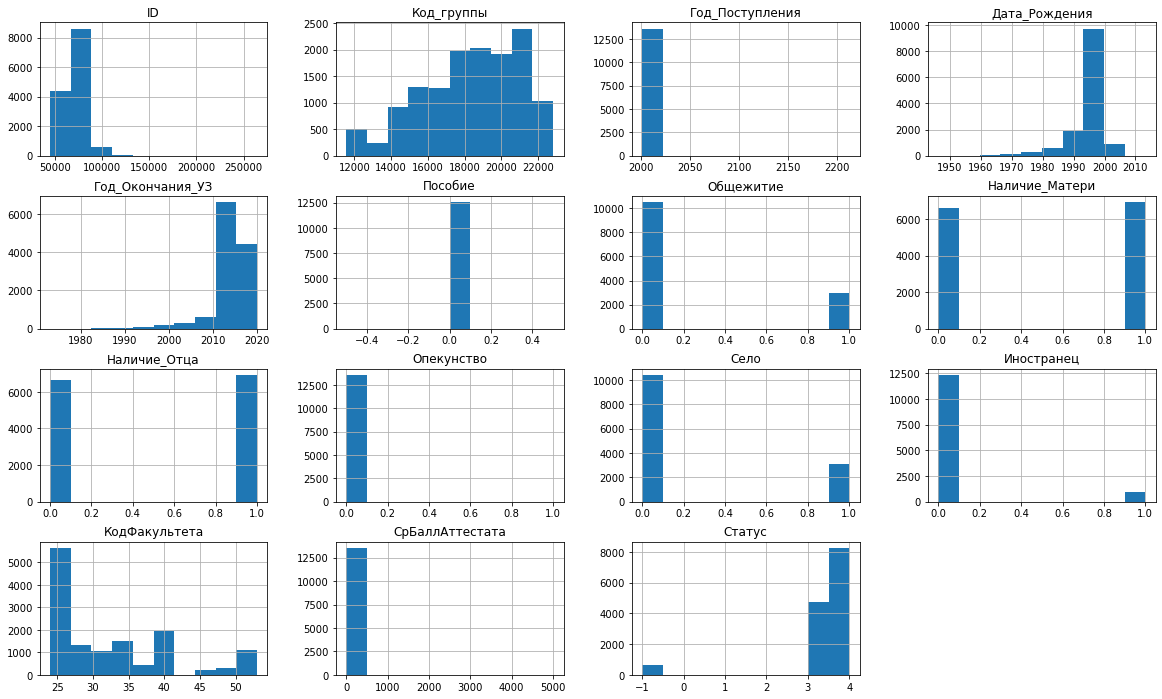

In [12]:
_ = df[df.columns].hist(figsize=(20,12))

Обратим внимание на часть столбцов с постоянными значениями

In [13]:
df["Пособие"].value_counts()

0.0    12576
Name: Пособие, dtype: int64

In [14]:
df["Опекунство"].value_counts()

0.0    13578
1.0        6
Name: Опекунство, dtype: int64

In [15]:
df.columns.values

array(['ID', 'Код_группы', 'Год_Поступления', 'Пол', 'Основания',
       'Изучаемый_Язык', 'Дата_Рождения', 'Уч_Заведение',
       'Где_Находится_УЗ', 'Год_Окончания_УЗ', 'Пособие', 'Страна_ПП',
       'Регион_ПП', 'Город_ПП', 'Общежитие', 'Наличие_Матери',
       'Наличие_Отца', 'Страна_Родители', 'Опекунство', 'Село',
       'Иностранец', 'КодФакультета', 'СрБаллАттестата', 'Статус'],
      dtype=object)

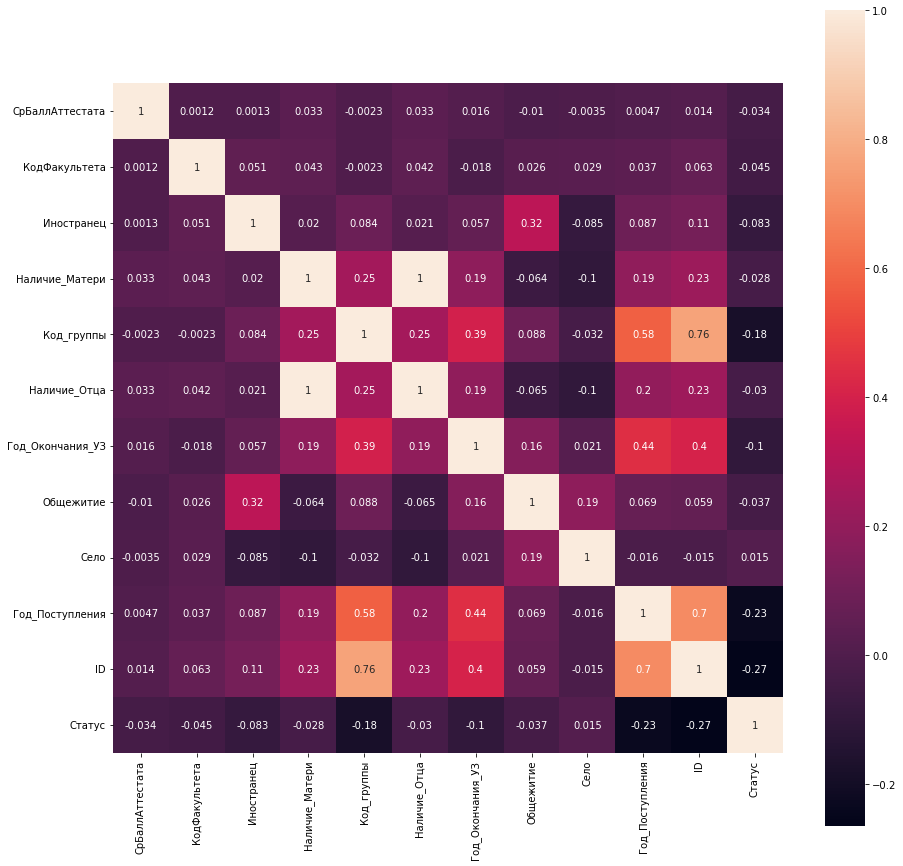

In [16]:
plt.rcParams['figure.figsize']=(15,15)


df_corr = list(set(df.columns.values) - set(['Опекунство','Пособие']))
g = sns.heatmap(df[df_corr].corr(), square = True, annot=True)

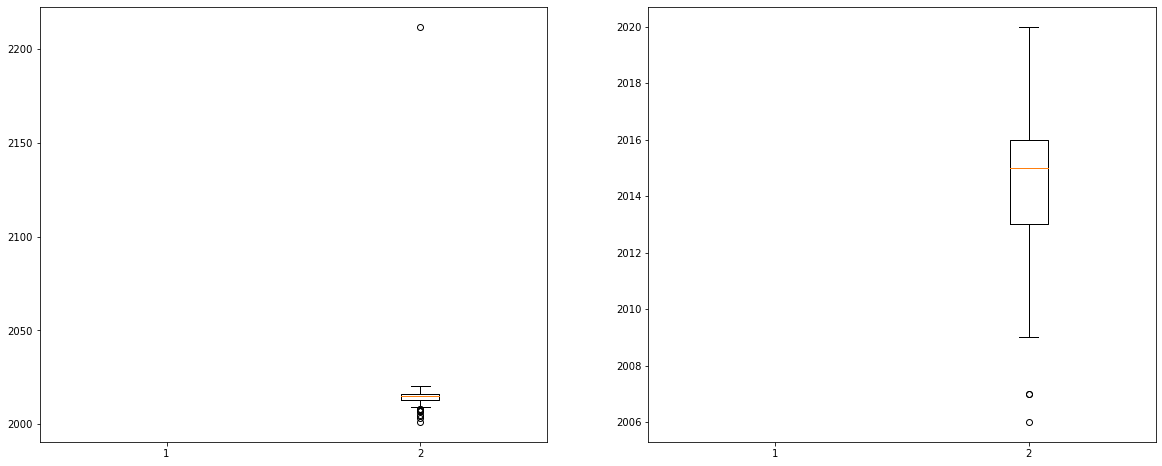

In [17]:
fig = plt.figure(figsize=(20,8))

ax_1 = fig.add_subplot(1,2,1)
ax_1 = plt.boxplot(df[['Год_Окончания_УЗ', 'Год_Поступления']])

ax_2 = fig.add_subplot(1,2,2)
ax_2 = plt.boxplot(df_test[['Год_Окончания_УЗ', 'Год_Поступления']])



In [18]:
# sns.pairplot(df, hue='Статус')

**Вывод**

1. В наборе данных представлена информация о студентах поступивших в АГУ в период с 2001 по 2020 год. Данные студенты закончили предидущее учебное заведение с 1966 года по 2020г. 
2. Присутствует дизбаланс классов целевого признака. Необходимо учесть это при обучении моделей.
3. Присутствуют пропуски в колонках:`Пол`,`Изучаемый_Язык`, `Уч_Заведение`, `Где_Находится_УЗ`, `Год_Окончания_УЗ`, `Пособие`, `Страна_ПП`, `Регион_ПП`, `Город_ПП`, `Общежитие`, `Страна_Родители`, `Село`, `Иностранец`. Их необходимо будет обработать.
4. Колонка `Пособие` - данные в ней являются константой. Использовать её для обучения модели не целесообразно.
4. Не достоверные данные:
    - `Год_Поступления` - 2212 - необходимо решить как заменить данную нереальную цифру.
    - `СрБаллАттестата` - Представлены данные о баллах ЕГЭ и оценках. Необходимо привести к единому виду.

## 2. Подготовка данных

1. Обработка данных:
    - Обработка пропусков
    - Обработка текстовых признаков
    - Обработка недостоверных данных и выбросов.
2. Подготовка признаков.
3. Подготовка выборок для обучения модели.

### 2.1 Обработка данных.
#### 2.1.1 Обработка пропусков.

Пропуски обработаем следующим образом:
- `Пол` - заменим на "Неизвестно";
- `Год_Окончания_УЗ` - заполним годом поступления;
- `Год_Поступления` - заполним годом окончания УЗ;
- `Пособие`, `Общежитие`, `Село`, `Иностранец` - заменим на "0".

In [19]:
# Пропущенный год окончания УЗ = году поступления
df.loc[df['Год_Окончания_УЗ'].isna(), 'Год_Окончания_УЗ'] = df.loc[df['Год_Окончания_УЗ'].isna(), 'Год_Поступления']
df_test.loc[df_test['Год_Окончания_УЗ'].isna(), 'Год_Окончания_УЗ'] = df_test.loc[df_test['Год_Окончания_УЗ'].isna(), 'Год_Поступления']
# Пропущенный год поступления = году окончания УЗ
df.loc[df['Год_Поступления'].isna(), 'Год_Поступления'] = df.loc[df['Год_Поступления'].isna(), 'Год_Окончания_УЗ']
df_test.loc[df_test['Год_Поступления'].isna(), 'Год_Поступления'] = df_test.loc[df_test['Год_Поступления'].isna(), 'Год_Окончания_УЗ']

In [20]:
# Список колонок типа float
mass_float = df.dtypes[df.dtypes == "float64"].index.values

df[mass_float] = df[mass_float].astype('int64', errors='ignore')

In [21]:
# Список колонок типа object
mass_object = df.dtypes[df.dtypes == "object"].index.values
# Список колонок числовых типов
mass_numeryc = df.dtypes[(df.dtypes == "int64")|(df.dtypes == "float64")].index.values
mass_numeryc

array(['ID', 'Код_группы', 'Год_Поступления', 'Год_Окончания_УЗ',
       'Пособие', 'Общежитие', 'Наличие_Матери', 'Наличие_Отца',
       'Опекунство', 'Село', 'Иностранец', 'КодФакультета',
       'СрБаллАттестата', 'Статус'], dtype=object)

In [22]:
df[mass_object] = df[mass_object].fillna('неизвестно')
df[mass_numeryc] = df[mass_numeryc].fillna(0)

df_test[mass_object] = df_test[mass_object].fillna('неизвестно')
df_test[np.delete(mass_numeryc, -1)] = df_test[np.delete(mass_numeryc, -1)].fillna(0)

**Вывод:** Пропуски заполнены.

#### 2.1.2 Текстовые признаки

В текстовых признаках многие одинаковые по смыслу данные имеют разное написание. В ходе обработки необходимо учитывать данный факт.
Обработаем текстовые признаки  следующим образом:
- `Изучаемый_Язык` - заменим на "Английский язык", так как он изучается наибольшим числом студентов.
- `Уч_Заведение` - выделим только типы учебных заведений: университет, СОШ, ПТУ, и другие.
- `Где_Находится_УЗ` - так как большинство УЗ находятся в Алтайском крае, выделим только УЗ в Алтайском крае и в другиз НП.
- `Страна_ПП` - выделим страны: 'россия', 'казахстан', 'кыргызстан', 'таджикистан'.
- `Регион_ПП` - выделим Алтайский край и все другие.
- `Город_ПП` - выделим Барнаул и все остальные.
- `Страна_Родители` - - выделим страны: 'россия', 'казахстан', 'кыргызстан', 'таджикистан'.

In [23]:
df['Пол'] = df['Пол'].apply(str.lower)
df_test['Пол'] = df_test['Пол'].apply(str.lower)
# df['Пол'].value_counts()

In [24]:
def lang_search(text):
    text = str.lower(text)
    if re.search(r'англ', text):
        return 'английский'
    elif re.search(r'немецкий', text):
        return 'немецкий'
    elif re.search(r'французский', text):
        return 'французский'
    elif  re.search(r'русский', text):
        return 'русский'
    # return 'неизвстно'
    return 'английский'

df['Изучаемый_Язык'] = df['Изучаемый_Язык'].apply(lang_search)
df_test['Изучаемый_Язык'] = df_test['Изучаемый_Язык'].apply(lang_search)

In [25]:
def learn_search(text):
    text = str.lower(text)
    if re.search(r'универ', text) or re.search(r'гу', text):
        return 'универ'
    elif re.search(r'сош', text) or re.search(r'школа', text) or re.search(r'сш', text):
        return 'сош'
    elif re.search(r'гимназ', text):
        # return 'гимназия'
        return 'сош'
    elif  re.search(r'колледж', text):
        # return 'колледж'
        return 'сош'
    elif  re.search(r'лицей', text):
        # return 'лицей'
        return 'сош'
    elif  re.search(r'академ', text):
        # return 'академия'
        return 'универ'
    elif  re.search(r'инсти', text):
        # return 'институт'
        return 'универ'
    elif  re.search(r'техник', text):
        # return 'техникум'
        return 'сош'
    elif  re.search(r'кадет', text):
        # return 'кадет'
        return 'сош'
    elif  re.search(r'профессио', text):
        return 'пту'
    return 'другое'
    # return 'сош'

df['Уч_Заведение'] = df['Уч_Заведение'].apply(learn_search)
df_test['Уч_Заведение'] = df_test['Уч_Заведение'].apply(learn_search)

In [26]:
# df['Где_Находится_УЗ'].value_counts().head(30)

In [27]:
def situation_search(text):
    text = str.lower(text)
    if re.search(r'алтай', text) or re.search(r'барнаул', text):
        return 'алтай'
    
    return 'другой'

df['Где_Находится_УЗ'] = df['Где_Находится_УЗ'].apply(situation_search)
df_test['Где_Находится_УЗ'] = df_test['Где_Находится_УЗ'].apply(situation_search)


In [28]:
def country_search(text):
    text = str.lower(text)
    if re.search(r'рос', text):
        return 'россия'
    elif re.search(r'казах', text):
        return 'казахстан'
    elif re.search(r'таджик', text):
        return 'таджикистан'
    elif  re.search(r'кыргыз', text):
        return 'кыргызстан'
    elif re.search(r'киргиз', text):
        return 'кыргызстан'
    
    # return 'неизвестно'
    return 'россия'

df['Страна_ПП'] = df['Страна_ПП'].apply(country_search)
df_test['Страна_ПП'] = df_test['Страна_ПП'].apply(country_search)


In [29]:
def region_search(text):
    text = str.lower(text)
    if re.search(r'алтай', text):
        return 'алтай'
    
    return 'другой'

df['Регион_ПП'] = df['Регион_ПП'].apply(region_search)
df_test['Регион_ПП'] = df_test['Регион_ПП'].apply(region_search)

In [30]:
def city_search(text):
    text = str.lower(text)
    line = text.split(' ')
    max_i = 0
    max_item = 'неизвестно'
    for item in line:
        if len(item) > max_i:
            max_item = item
            max_i = len(item)
    if max_item != 'барнаул' and max_item != 'неизвестно':
        return 'другой'
    return max_item

df['Город_ПП'] = df['Город_ПП'].apply(city_search)
df_test['Город_ПП'] = df_test['Город_ПП'].apply(city_search)

In [31]:
df['Страна_Родители'] = df['Страна_Родители'].apply(country_search)
df_test['Страна_Родители'] = df_test['Страна_Родители'].apply(country_search)

**Вывод:** Текстовые данные обработаны.

#### 2.1.3 Недостоверные данные, выбросы

1. Заменим 2212 год в колонке `Год_Поступления` на 2012 как наиболее вероятное значение.
2. Приведём данные в колонке `СрБаллАттестата` к оценкам по пятибальной системе.

In [32]:
df.loc[104, 'Год_Поступления'] = 2012

In [33]:
df['СрБаллАттестата'].describe()

count    13584.000000
mean        73.223274
std        258.045027
min          0.000000
25%         47.000000
50%         61.000000
75%         75.000000
max       5000.000000
Name: СрБаллАттестата, dtype: float64

In [34]:
df_test['СрБаллАттестата'].describe()

count    6691.000000
mean       71.681369
std       250.386989
min         0.000000
25%        47.000000
50%        61.000000
75%        76.000000
max      7232.000000
Name: СрБаллАттестата, dtype: float64

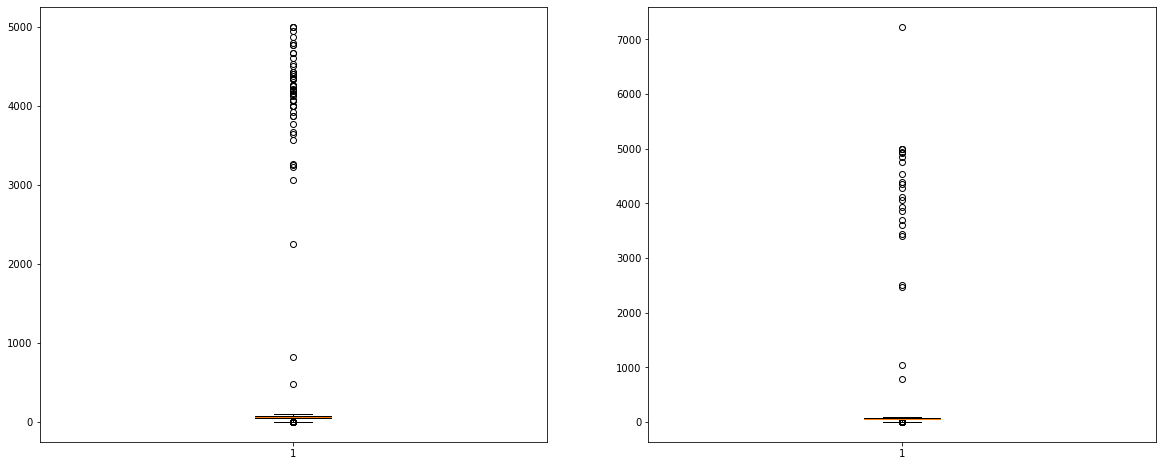

In [35]:
fig = plt.figure(figsize=(20,8))

ax_1 = fig.add_subplot(1,2,1)
ax_1 = plt.boxplot(df['СрБаллАттестата'])

ax_2 = fig.add_subplot(1,2,2)
ax_2 = plt.boxplot(df_test['СрБаллАттестата'])

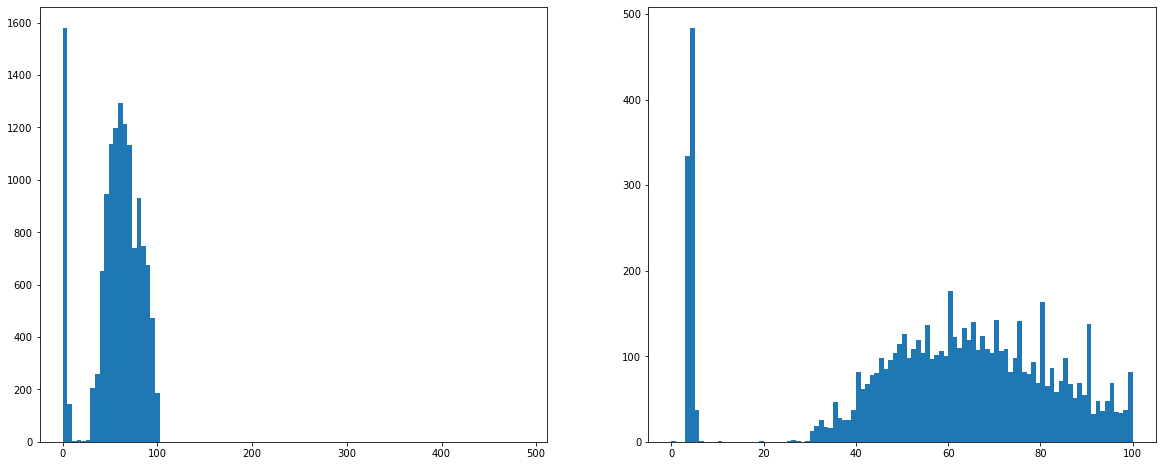

In [36]:
fig = plt.figure(figsize=(20,8))

ax_1 = fig.add_subplot(1,2,1)
ax_1.hist(df[(df['СрБаллАттестата'] > -1) & (df['СрБаллАттестата'] <500)]['СрБаллАттестата'], bins=100)
ax_2 = fig.add_subplot(1,2,2)
ax_2.hist(df_test[(df_test['СрБаллАттестата'] > -1) & (df_test['СрБаллАттестата'] <500)]['СрБаллАттестата'], bins=100)
plt.show;
# df[(df['СрБаллАттестата'] > -1) & (df['СрБаллАттестата'] <500)]['СрБаллАттестата'].hist(bins=100)

In [37]:
def preproc_attestat(ball):
    """ Принимаем значение среднего балла аттестата
        Возвращаем балл приведённый к 5-ти бальной системе оценок
    """
    if ball > 5000:
        return min((ball / 100 - 30) / 20 + 3, 5)
    elif ball > 1000:
        return ball / 1000
    elif ball > 500:
        return ball / 200
    elif ball > 100:
        return ball / 100
    elif ball > 29: 
        return min((ball - 30) / 20 + 3, 5)
    # elif ball > 10:
    #     return ball / 5
    elif ball > 5:
        # return ball / 2
        return 4
    elif ball == 0:
        return 4
        
    return ball

In [38]:
df['СрБаллАттестата'] = df['СрБаллАттестата'].apply(preproc_attestat)
df_test['СрБаллАттестата'] = df_test['СрБаллАттестата'].apply(preproc_attestat)

**Вывод:** Данные обработаны

### 2.2 Подготовка признаков

In [39]:
# Список категориальных признаков
category_columns = [
                    'Пол', 
                    'Основания', 
                    'Изучаемый_Язык',
                    # 'Дата_Рождения',
                    'Уч_Заведение', 
                    'Где_Находится_УЗ', 
                    'Страна_ПП', 
                    # 'Регион_ПП',
                    # 'Город_ПП', 
                    'Страна_Родители'
                   ]
# mass_object = df.dtypes[df.dtypes == "object"].index.values

In [40]:
# Список числовых признаков
numeric_columns = ['ID',
                   'Код_группы',
                   'Год_Поступления',
                   'Год_Окончания_УЗ',
                   # 'Пособие',
                   'Общежитие', 
                   # 'Наличие_Матери', 
                   # 'Наличие_Отца',
                   # 'Опекунство', 
                   'Село', 
                   'Иностранец', 
                   'КодФакультета',
                   'СрБаллАттестата',
                  ]

In [41]:
# Генерация дополнительных признаков
def create_features(data):
    """ Принимаем датасет
        Возвращаем датасет с добавлением признаков
    """
    data['Год_рождения'] = data['Дата_Рождения'].dt.year
    data['Возраст_поступления'] = data['Год_Поступления'] - data['Год_рождения']
    # df['Возраст_поступления_20'] = df['Возраст_поступления'].apply(lambda x: 1 if x > 18 else 0)
    data['лет_между'] = data['Год_Поступления'] - data['Год_Окончания_УЗ']
    data['Месяц_рождения'] = data['Дата_Рождения'].dt.month
    data['Месяц_рождения'] = data['Месяц_рождения'].apply(lambda x: 1 if (x > 4) and (x < 10) else 0)
    data['родители_иностранцы'] = data['Страна_Родители'].apply(lambda x: 0 if x == 'россия' else 1)
    # data['СрБаллАттестата'] = data['СрБаллАттестата'].apply(lambda x: x**2)
    data[['Код_группы_1','Код_группы_2']] = [_ for _ in data['Код_группы'].apply(lambda kod: [int(str(kod)[:3]), int(str(kod)[3:])])]
    
    # data['Год_рождения'] = data['Год_рождения'].apply(lambda x: (x - 2020)**2)
    # data['Год_Поступления'] = data['Год_Поступления'].apply(lambda x: (x - 2020)**2)
    # data['Год_Окончания_УЗ'] = data['Год_Окончания_УЗ'].apply(lambda x: (x - 2020)**2)
    
    data['Наличие_родителей'] =  data['Наличие_Матери'] +  data['Наличие_Отца'] - data['Опекунство']
    data['Супер_признак'] = np.sqrt(data['Студентов_в_группе']**2 + data['СрБаллАттестата']**2)
    return data

In [42]:
# Количество студентов в группе
# df_train_test = pd.concat([df, df_test])
# students_on_group = df_train_test.groupby('Код_группы')['ID'].count()

# Количество студентов в группе
students_on_group = df.groupby('Код_группы')['ID'].count()
students_on_group.name = 'Студентов_в_группе'
# students_on_group = students_on_group.apply(lambda x: x**2)
# students_on_group = students_on_group.apply(lambda x: max(x, 3))

# Добавляем в датасеты
df = df.merge(students_on_group, on='Код_группы', how='left')
df_test = df_test.merge(students_on_group, on='Код_группы', how='left')
df_test = df_test.fillna(1)

In [43]:
# Количество студентов на факультете
students_on_facult = df.groupby('КодФакультета')['ID'].count()
students_on_facult.name = 'Студентов_на_факультете'

df = df.merge(students_on_facult, on='КодФакультета')#, how='left')
df_test = df_test.merge(students_on_facult, on='КодФакультета', how='left')
df_test = df_test.fillna(df_test['Студентов_на_факультете'].median())

In [44]:
df.head()

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус,Студентов_в_группе,Студентов_на_факультете
0,72716,16019,2015,жен,ОО,английский,1998-02-08,сош,алтай,2014.0,...,0.0,россия,0.0,0.0,0.0,41.0,4.294,3,2,1485
1,82469,20103,2017,жен,ДН,английский,1999-03-21,сош,алтай,2017.0,...,1.0,россия,0.0,0.0,0.0,41.0,4.133,4,10,1485
2,72669,18733,2015,муж,СН,английский,1997-11-13,сош,алтай,2015.0,...,0.0,россия,0.0,0.0,0.0,41.0,3.692,3,2,1485
3,81843,20091,2017,жен,ОО,английский,2001-04-23,сош,алтай,2017.0,...,1.0,россия,0.0,0.0,0.0,41.0,4.470,3,1,1485
4,72581,17440,2015,жен,ОО,немецкий,1997-08-05,сош,алтай,2015.0,...,0.0,россия,0.0,0.0,0.0,41.0,4.600,4,7,1485


In [45]:
# Генерация дополнительных признаков

df = create_features(df)
df_test = create_features(df_test)
df.head()

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Студентов_на_факультете,Год_рождения,Возраст_поступления,лет_между,Месяц_рождения,родители_иностранцы,Код_группы_1,Код_группы_2,Наличие_родителей,Супер_признак
0,72716,16019,2015,жен,ОО,английский,1998-02-08,сош,алтай,2014.0,...,1485,1998,17,1.0,0,0,160,19,0.0,4.736923
1,82469,20103,2017,жен,ДН,английский,1999-03-21,сош,алтай,2017.0,...,1485,1999,18,0.0,0,0,201,3,2.0,10.820429
2,72669,18733,2015,муж,СН,английский,1997-11-13,сош,алтай,2015.0,...,1485,1997,18,0.0,0,0,187,33,0.0,4.198912
3,81843,20091,2017,жен,ОО,английский,2001-04-23,сош,алтай,2017.0,...,1485,2001,16,0.0,0,0,200,91,2.0,4.580491
4,72581,17440,2015,жен,ОО,немецкий,1997-08-05,сош,алтай,2015.0,...,1485,1997,18,0.0,1,0,174,40,0.0,8.376157


In [46]:
features_columns = [
                    'Год_рождения',
                    # 'Возраст_поступления',
#     !!!!!!!!!!!
                    # 'лет_между',
                    # 'Месяц_рождения',
                    # 'Возраст_поступления_20',
                    'Студентов_в_группе',
                    # 'Студентов_на_факультете',
                    # 'родители_иностранцы',
                    # 'Код_группы_1',
                    'Код_группы_2',
                    # 'Наличие_родителей',
                    # 'Супер_признак',
]

In [47]:
# Преобразуем тип даннных категориальных признаков из object в category для правильной работы в LGBM
df[mass_object] = df[mass_object].astype('category')
df_test[mass_object] = df_test[mass_object].astype('category')

**Вывод:** Признаки сформированы.

## Выделим выборки

In [48]:
X = df[category_columns + numeric_columns + features_columns]

y = df[["Статус"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = 99999)

preprocessor_OHE = ColumnTransformer(transformers=[#('num', Normalizer(), numeric_columns+features_columns),
                                                   ('cat', OneHotEncoder(drop='first', 
                                                                         handle_unknown='ignore'), category_columns)
                                                  ],
                                     remainder='passthrough'
                                    )


# X_train[category_columns] = encoder.fit_transform(X_train[category_columns])
X_original = X.copy()
X[category_columns] = encoder.fit_transform(X[category_columns])
# X = oh_encoder.fit_transform(X)
# st_scaller = StandardScaler()
# X = st_scaller.fit_transform(X)

# X.head()

X_original.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Пол,Основания,Изучаемый_Язык,Уч_Заведение,Где_Находится_УЗ,Страна_ПП,Страна_Родители,ID,Код_группы,Год_Поступления,Год_Окончания_УЗ,Общежитие,Село,Иностранец,КодФакультета,СрБаллАттестата,Год_рождения,Студентов_в_группе,Код_группы_2
0,жен,ОО,английский,сош,алтай,россия,россия,72716,16019,2015,2014.0,0.0,0.0,0.0,41.0,4.294,1998,2,19
1,жен,ДН,английский,сош,алтай,россия,россия,82469,20103,2017,2017.0,0.0,0.0,0.0,41.0,4.133,1999,10,3
2,муж,СН,английский,сош,алтай,россия,россия,72669,18733,2015,2015.0,0.0,0.0,0.0,41.0,3.692,1997,2,33
3,жен,ОО,английский,сош,алтай,россия,россия,81843,20091,2017,2017.0,0.0,0.0,0.0,41.0,4.470,2001,1,91
4,жен,ОО,немецкий,сош,алтай,россия,россия,72581,17440,2015,2015.0,1.0,0.0,0.0,41.0,4.600,1997,7,40


In [49]:
X.shape

(13584, 19)

In [50]:
X_ohe = preprocessor_OHE.fit_transform(X_original)
X_ohe.shape 

(13584, 31)

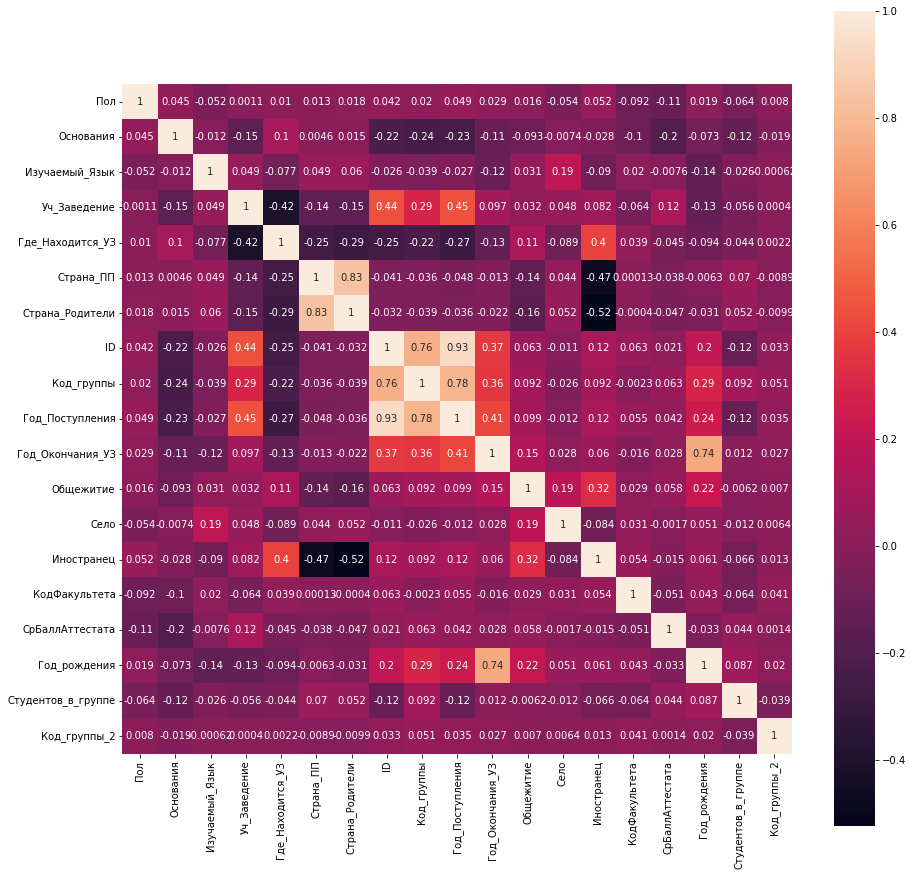

In [51]:
# Анализ итоговой таблицы признаков
plt.rcParams['figure.figsize']=(15,15)

# X_corr = list(set(X.columns.values) - set(['Опекунство','Пособие']))
g = sns.heatmap(X[category_columns + numeric_columns + features_columns].corr(), square = True, annot=True)

In [52]:
# sns.pairplot(df[category_columns + numeric_columns + features_columns + ['Статус']], hue='Статус')

**Вывод**

1. Данные обработаны.
2. Сгенерированы дополнительные признаки.
3. Подготовлены выборки к обучению моделей.

## 3. Обучение модели

Обучим несколько моделей МО с подбором гиперпараметров и выберем лучшую:
1. RandomForestClassifier
2. CatBoostClassifier
3. LightGBMClassifier
4. XGBoostClassifier

В даннои ноутбуке я оставил только модель, показавшую максимальнуое качество - CatBoostClassifier

### CatBoostClassifier

In [53]:
# %%time
# cb_clf = CatBoostClassifier(learning_rate=0.3,
#                             l2_leaf_reg=18,
#                             depth=7,
#                             silent=True,
#                             iterations=400,
#                             auto_class_weights='SqrtBalanced',
#                             random_state=12345)
# cb_clf.fit(X_train, y_train, cat_features=category_columns, silent=True)
# pred = cb_clf.predict(X_test)
# f1_score(y_test, pred, average='macro', zero_division = 0) 

CPU times: total: 3min 12s
Wall time: 48.4 s


0.7753364623600126

In [54]:
# %%time
# # CatBoost с автоподбором параметров
# parametrs = { 'l2_leaf_reg': range(1,30),
#               'learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.5, 0.8, 1],
#               'depth' : range(1,10)
# }

# cb_clf = CatBoostClassifier(iterations=1000,
#                             auto_class_weights='SqrtBalanced',
#                             silent=True)
# randCV_cat = RandomizedSearchCV(cb_clf, 
#                                 parametrs, 
#                                 scoring='f1_macro', 
#                                 cv=5, 
#                                 n_iter=10,
#                                 n_jobs=-1,
#                                 random_state=5555)
# randCV_cat.fit(X_ohe, y)
# print('Параметры модели:', randCV_cat.best_params_)
# print('Лучший f1 модели:', randCV_cat.best_score_)

In [55]:
# %%time
# # CatBoost с автоподбором параметров
# parametrs = { 'l2_leaf_reg': range(15,22),
#               'learning_rate': [0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33],
#               'depth' : range(5,9)
# }

# cb_clf = CatBoostClassifier(iterations=500,
#                             auto_class_weights='SqrtBalanced',
#                             silent=True)
# gridCV_cat = GridSearchCV(cb_clf,
#                            parametrs,
#                            scoring='f1_macro',
#                            cv=5,
#                            n_jobs=-1,
#                          )
# gridCV_cat.fit(X_ohe, y)
# print('Параметры модели:', gridCV_cat.best_params_)
# print('Лучший f1 модели:', gridCV_cat.best_score_)

In [54]:
%%time
cb_clf = CatBoostClassifier(learning_rate=0.28, #0.15
                            l2_leaf_reg=18,     # 22
                            depth=7,            # 5
                            # loss_function='MultiClassOneVsAll',
                            silent=True,
                            iterations=500,     # 1000
                            auto_class_weights='SqrtBalanced',
                            random_state=12345
                           )

cv_score = cross_val_score( cb_clf, 
                            # X_ohe, 
                            X,
                            y, 
                            n_jobs=-1, 
                            scoring='f1_macro')
np.mean(cv_score)

CPU times: total: 78.1 ms
Wall time: 13.8 s


0.7217548240444192

**Вывод**

Несмотря на то, что значение F1 у данной модели на кросвалидации оказалось давольно небольшим, на тестовом датасете оно максимальное из рассмотренных моделей и равно 0.799. Также, были примены различные методы кодирования категориальных признаков: OE, OHE и с самостоятельным кодированием внутри модели. Наилучшее качество модель показала со способом кодирования OE.

### LGBMClassifier

In [57]:
%%time
lgbm_clf = LGBMClassifier(n_estimators=200, 
                          learning_rate=0.07,
                          max_depth=66,
                          # boosting_type='goss',
                          random_state=12345,
                          num_leaves=51,
                          # class_weight='balanced',
                           )

np.mean(cross_val_score(lgbm_clf, 
                        # X,
                        X_original, 
                        # X_ohe,
                        y, 
                        n_jobs=-1, 
                        scoring='f1_macro'))

CPU times: total: 31.2 ms
Wall time: 4.28 s


0.6986881411222658

In [280]:
# %%time
# # LGBMRegressor с автоподбором параметров
# parametrs = { 'n_estimators': range(200, 401, 10),
#               'learning_rate': [0.001, 0.003, 0.005, 0.008, 0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.5],
#               'max_depth': range(20,70),
#               'num_leaves': range(30,80),
#             }

# lgbm_clf = LGBMClassifier(random_state=12345)
# randCV_lgbm = RandomizedSearchCV(lgbm_clf, 
#                                  parametrs, 
#                                  scoring='f1_macro',
#                                  cv=5,
#                                  n_iter=20,
#                                  n_jobs=-1,
#                                  random_state=5555
#                                  )
# randCV_lgbm.fit(X_original, y)
# print('Параметры модели:', randCV_lgbm.best_params_)
# print('Лучший F1 модели:', randCV_lgbm.best_score_)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Параметры модели: {'num_leaves': 51, 'n_estimators': 200, 'max_depth': 66, 'learning_rate': 0.07}
Лучший F1 модели: 0.7825482880628577
CPU times: total: 7.36 s
Wall time: 1min


Параметры модели: {'num_leaves': 51, 'n_estimators': 200, 'max_depth': 66, 'learning_rate': 0.07}
Лучший F1 модели: 0.7825482880628577
CPU times: total: 7.36 s
Wall time: 1min

Параметры модели: {'n_estimators': 200, 'learning_rate': 0.02}
Лучший F1 модели: 0.7202722350746995
CPU times: total: 2min 30s3

**Вывод**

Модель LGBM, также как и CatBoost на тестовых данных показывает давольно не плохое значение метрики F1=0.782

### XGBoostClassifier

In [58]:
# XGBoost требует преобразования целевого признака от вида -1,3,4 к виду 0,1,2
def y_for_xgb(data):

    yy = []
    for i in data['Статус']:
        i -= 2
        yy.append(max(0,i))
    return yy

def y_convert(data):
    
    result = []
    
    for i in data:
        i += 2
        if i == 2:
            i = -1
        result.append(i)
    return result
    
yy = y_for_xgb(y)


In [59]:
%%time
xgb_clf = XGBClassifier(n_estimators=450, 
                        learning_rate=0.05,
                        max_depth=46,
                        n_jobs=-1,
                        random_state=12345,
                        # num_parallel_tree=2,
                        # class_weight='balanced',
                        # enable_categorical=True
                       )

np.mean(cross_val_score(xgb_clf, 
                        X,
                        # X_original, 
                        yy, 
                        n_jobs=-1, 
                        scoring='f1_macro'))

CPU times: total: 93.8 ms
Wall time: 1min 16s


0.7108290201016491

In [286]:
# %%time
# # XGBClassifier с автоподбором параметров
# parametrs = { 'n_estimators': range(200, 501, 10),
#               'learning_rate': [0.001, 0.003, 0.005, 0.008, 0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.5],
#               'max_depth': range(5,70),
#               # 'num_leaves': range(30,80),
#             }

# xgb_clf = XGBClassifier(random_state=12345)
# randCV_xgb = RandomizedSearchCV(xgb_clf, 
#                                 parametrs, 
#                                 scoring='f1_macro',
#                                 cv=5,
#                                 n_iter=10,
#                                 n_jobs=-1,
#                                 random_state=5555
#                                )
# randCV_xgb.fit(X, yy)
# print('Параметры модели:', randCV_xgb.best_params_)
# print('Лучший F1 модели:', randCV_xgb.best_score_)

Параметры модели: {'n_estimators': 450, 'max_depth': 46, 'learning_rate': 0.05}
Лучший F1 модели: 0.7766173673722121
CPU times: total: 2min 33s
Wall time: 7min 40s


Параметры модели: {'n_estimators': 450, 'max_depth': 46, 'learning_rate': 0.05}
Лучший F1 модели: 0.7766173673722121
CPU times: total: 2min 33s
Wall time: 7min 40s

**Вывод**

Модель XGB на тестовых данных показывает наихудшую метрику качества F1=0.760? хотя на кросвалидации она лучшая.

**Вывод**

Наилучшее качество на тестовых данных показывает CatBoost, затем LightGbm и затем XGBoost. Для окончательного результата имеет смысл использовать технику blanding. Это должно увеличить итоговое качество модели и повысить стабильность её работы.

# 4. Cоздание файла с ответом

1. Обучим модели CatBoost, LighiGBM и XGBoost на полном наборе тренировочного датасета.
2. Прогнозируемые вероятности моделей полученные на тестовых данных смешаем в пропорции 5/3/2 и запишем результат в файл.
3. Проанализируем важность признаков.

## 4.1 Обучение моделей на полном наборе тренировочных данных.

In [60]:
# обучаем модели на всём наборе данных
cb_clf.fit(X, y, silent=True)
lgbm_clf.fit(X_original, y)
xgb_clf.fit(X, yy)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=46, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=450,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=12345, reg_alpha=0, ...)

## 4.2 Получение прогноза на тестовом датасете.

In [61]:
# Получаем прогнозируемые вероятности классов
X_submint = df_test[category_columns + numeric_columns + features_columns]
lgb_proba = lgbm_clf.predict_proba(X_submint)

X_submint[category_columns] = encoder.transform(X_submint[category_columns])
cat_proba = cb_clf.predict_proba(X_submint)
xgb_proba = xgb_clf.predict_proba(X_submint)




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [62]:
# Смешиваем в необходимых пропорциях
df_submission[[-1,3,4]] = cat_proba*0.5 + lgb_proba*0.3 + xgb_proba*0.2

df_submission.head()

,ID,Статус,-1,3,4
0,64996,NaN,0.003554,0.021154,0.975292
1,71837,NaN,0.021517,0.010742,0.967741
2,86587,NaN,0.334311,0.290339,0.375350
3,73673,NaN,0.868266,0.117788,0.013947
4,54709,NaN,0.000057,0.023855,0.976089


In [63]:
# Заполняем колонку целевого признака
df_submission["Статус"] = df_submission[[-1,3,4]].apply(lambda x: x.idxmax(), axis=1)

In [65]:
# df_submission["Статус"] = df_test_pred
df_submission.head(4)

,ID,Статус,-1,3,4
0,64996,4,0.003554,0.021154,0.975292
1,71837,4,0.021517,0.010742,0.967741
2,86587,4,0.334311,0.290339,0.375350
3,73673,-1,0.868266,0.117788,0.013947


In [67]:
df_submission[['ID','Статус']].to_csv("submission_140 bag merge 5 3 2.csv", index=False)

## 4.3 Оценка важности факторов

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


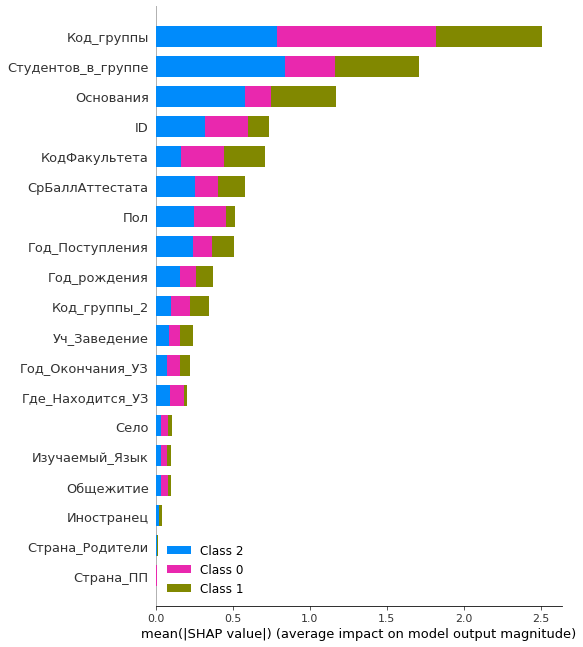

In [68]:
shap_test = shap.TreeExplainer(cb_clf).shap_values(X)
shap.summary_plot(shap_test, X, max_display=25, auto_size_plot=True)

**Вывод**

1. С помощью модели CatBoostClassifier, удалось достичь метрики качества F1=0.7992 на закрытой части тестовых данных.
2. С помоoщью техники блэндинга удалось увеличить метрику качества на 0.0002 до 0.7994. Надеюсь, блэнгдинг придаст результату стабильности, для достижения наилучшего результата на закрытой части тестового датасета.
3. Анализ важности признаков говорит о том, что большой вклад в качество полученной модели внесли сгенерированные признаки `Количество студентов в группе` и `Код группы 2`.

# Общий вывод

1. На этапе анализа данных были выявлены проблемные вопросы и особенности данных.
2. На этапе обработки данных были обработаны пропуски, недостоверные данные и текстовые данные. Сгенерированы дополнительные признаки и подготовлены выборки. Не все признаки присутствующие в наборе данных и которые были дополнительно сгенерировы положительно влияли на качество модели.
3. Были обучены несколько моделей машинного обучения, из которых наибольшее значение метрики качества показывала модель CatBoostClassifier.
4. С помоoщью техники блэндинга удалось увеличить метрику качества на 0.0002 до 0.7994. Надеюсь, блэнгдинг придаст результату стабильности, для достижения наилучшего результата на закрытой части тестового датасета.
4. На закрытой части тестового набора данных построенная модель показала F1=0.7994. Значительный вклад в качество модели внесли сгенерированные признаки `Количество студентов в группе` и `Код группы 2`.